## 1. Load & Explore Data

In [1]:
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import joblib
import os
from tqdm import tqdm

dask.config.set({"dataframe.convert-string": False})

In [2]:

# Load train data
dataset_path = "./smadex-challenge-predict-the-revenue/train/train"
filters = [("datetime", ">=", "2025-10-01-00-00"), ("datetime", "<", "2025-10-01-12-00")]
ddf = dd.read_parquet(dataset_path, filters=filters)

print(f"Dataset: {ddf.shape[0].compute()} rows, {len(ddf.columns)} columns")

Dataset: 1530501 rows, 85 columns


## 2. Feature Engineering (Top 15 features)

In [3]:
# === CARGAR SAMPLE CON PROGRESS BAR ===
print("Loading sample data...")
sample_frac = 0.3  # 30% para reducir memoria
try:
    print("  - Sampling...", end="", flush=True)
    sampled_ddf = ddf.sample(frac=sample_frac, random_state=42)
    print(" ✓")
    
    print("  - Computing...", end="", flush=True)
    df = sampled_ddf.compute()
    print(" ✓")
except Exception as e:
    print(f"\n⚠️  Sample failed, using first partition...")
    df = ddf.get_partition(0).compute()
    
print(f"✓ Sample loaded: {len(df)} rows, {len(df.columns)} columns")

# === PREPARAR FEATURES ===
target = "iap_revenue_d7"
if target not in df.columns:
    raise ValueError(f"Target '{target}' not found!")

y = df[target].values
print(f"Target: {y.shape}, min={y.min():.2f}, max={y.max():.2f}")

# Seleccionar solo columnas numéricas (excluyendo row_id y target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target and c != 'row_id']
print(f"Numeric features: {len(numeric_cols)}")

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found!")

# Crear X con fillna
X = df[numeric_cols].fillna(0)
print(f"After fillna: {X.shape}")

# === FILTRO SIMPLE DE VARIANZA ===
print("\nFiltering low-variance features...")
stds = X.std()
high_var_cols = stds[stds > 0.01].index.tolist()

if len(high_var_cols) == 0:
    print("⚠️  Using top 50 by variance")
    high_var_cols = stds.nlargest(50).index.tolist()
    
X = X[high_var_cols]
print(f"✓ Final features: {X.shape}")

# Liberar memoria del dataframe original
del df
import gc
gc.collect()

Loading sample data...
  - Sampling... ✓
  - Computing... ✓
  - Computing... ✓
✓ Sample loaded: 459150 rows, 85 columns
Target: (459150,), min=0.00, max=696622.14
Numeric features: 26
 ✓
✓ Sample loaded: 459150 rows, 85 columns
Target: (459150,), min=0.00, max=696622.14
Numeric features: 26
After fillna: (459150, 26)

Filtering low-variance features...
After fillna: (459150, 26)

Filtering low-variance features...
✓ Final features: (459150, 25)
✓ Final features: (459150, 25)


41

## 3. Transform Target (LOG1P)

In [4]:
# === PREPARAR TARGET PARA DOS MODELOS ===
# 1. Clasificador: ¿hay compra (y > 0) o no?
y_binary = (y > 0).astype(int)

# 2. Regresor: SOLO para los que compran (y > 0) - CRITICAL FIX
mask_positive = y > 0
X_positive = X[mask_positive].reset_index(drop=True)
y_positive = y[mask_positive]
y_positive_log = np.log1p(y_positive)

print(f"Original y: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")
print(f"Binary target (has_purchase): {y_binary.sum()} positivos, {(1-y_binary).sum()} negativos ({y_binary.mean()*100:.1f}%)")
print(f"Positive only: {len(y_positive)} samples (log: min={y_positive_log.min():.4f}, max={y_positive_log.max():.4f}, mean={y_positive_log.mean():.4f})")

# Train/val split para CLASIFICADOR (en TODOS los datos)
X_train, X_val, y_train_binary, y_val_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)
_, _, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train/val split para REGRESOR (SOLO en datos positivos)
X_train_pos, X_val_pos, y_train_pos_log, y_val_pos_log = train_test_split(
    X_positive, y_positive_log, test_size=0.2, random_state=42
)

print(f"\nClassifier Train: {len(X_train)} (positivos: {y_train_binary.sum()}) | Val: {len(X_val)} (positivos: {y_val_binary.sum()})")
print(f"Regressor Train: {len(X_train_pos)} | Val: {len(X_val_pos)}")

Original y: min=0.00, max=696622.14, mean=2.94
Binary target (has_purchase): 12667 positivos, 446483 negativos (2.8%)
Positive only: 12667 samples (log: min=0.0014, max=13.4540, mean=2.3335)

Classifier Train: 367320 (positivos: 10107) | Val: 91830 (positivos: 2560)
Regressor Train: 10133 | Val: 2534

Classifier Train: 367320 (positivos: 10107) | Val: 91830 (positivos: 2560)
Regressor Train: 10133 | Val: 2534


## 4. Train LightGBM (Optimized for MSLE)

In [5]:
# === MODELO 1: CLASIFICADOR (¿compra o no?) ===
print("="*80)
print("TRAINING CLASSIFIER (Purchase: Yes/No)")
print("="*80)

print(f"\nTraining data shapes: X_train={X_train.shape}, y_train_binary={y_train_binary.shape}")
print(f"Validation data shapes: X_val={X_val.shape}, y_val_binary={y_val_binary.shape}")

classifier = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    num_leaves=31,
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    force_row_wise=True
)

print("Training classifier...")
try:
    classifier.fit(
        X_train, y_train_binary,
        eval_set=[(X_val, y_val_binary)],
        callbacks=[
            lgb.log_evaluation(period=50),
            lgb.early_stopping(stopping_rounds=30)
        ]
    )
    print("✓ Classifier training completed!")
except Exception as e:
    print(f"✗ Training failed: {str(e)}")
    raise

# === MODELO 2: REGRESOR (¿cuánto compra?) ===
print("\n" + "="*80)
print("TRAINING REGRESSOR (Revenue Amount - POSITIVE SAMPLES ONLY)")
print("="*80)

print(f"\nTraining data shapes: X_train_pos={X_train_pos.shape}, y_train_pos_log={y_train_pos_log.shape}")
print(f"Validation data shapes: X_val_pos={X_val_pos.shape}, y_val_pos_log={y_val_pos_log.shape}")

regressor = lgb.LGBMRegressor(
    objective='regression_l2',
    metric='mse',
    num_leaves=31,
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    force_row_wise=True
)

print("Training regressor on log-transformed target (POSITIVE SAMPLES ONLY)...")
try:
    regressor.fit(
        X_train_pos, y_train_pos_log,
        eval_set=[(X_val_pos, y_val_pos_log)],
        callbacks=[
            lgb.log_evaluation(period=50),
            lgb.early_stopping(stopping_rounds=30)
        ]
    )
    print("✓ Regressor training completed!")
except Exception as e:
    print(f"✗ Training failed: {str(e)}")
    raise

print("\n" + "="*80)
print("Models trained successfully!")
print("="*80)

TRAINING CLASSIFIER (Purchase: Yes/No)

Training data shapes: X_train=(367320, 25), y_train_binary=(367320,)
Validation data shapes: X_val=(91830, 25), y_val_binary=(91830,)
Training classifier...
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.0042849
[50]	valid_0's binary_logloss: 0.0042849
[100]	valid_0's binary_logloss: 0.000360159
[100]	valid_0's binary_logloss: 0.000360159
[150]	valid_0's binary_logloss: 4.1539e-05
[150]	valid_0's binary_logloss: 4.1539e-05
[200]	valid_0's binary_logloss: 1.04514e-05
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 1.04514e-05
✓ Classifier training completed!

TRAINING REGRESSOR (Revenue Amount - POSITIVE SAMPLES ONLY)

Training data shapes: X_train_pos=(10133, 25), y_train_pos_log=(10133,)
Validation data shapes: X_val_pos=(2534, 25), y_val_pos_log=(2534,)
Training regressor on log-transformed target (POSITIVE

## 5. Evaluation & MSLE Metrics

In [6]:
# === EVALUACIÓN CLASIFICADOR ===
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

y_pred_prob_train = classifier.predict_proba(X_train)[:, 1]
y_pred_prob_val = classifier.predict_proba(X_val)[:, 1]
y_pred_binary_train = classifier.predict(X_train)
y_pred_binary_val = classifier.predict(X_val)

auc_val = roc_auc_score(y_val_binary, y_pred_prob_val)
precision, recall, f1, _ = precision_recall_fscore_support(y_val_binary, y_pred_binary_val, average='binary')

print(f"\n=== CLASSIFIER Metrics ===")
print(f"Val AUC: {auc_val:.4f}")
print(f"Val Precision: {precision:.4f}")
print(f"Val Recall: {recall:.4f}")
print(f"Val F1: {f1:.4f}")
tn, fp, fn, tp = confusion_matrix(y_val_binary, y_pred_binary_val).ravel()
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

# === EVALUACIÓN REGRESOR (dos etapas) ===
# El regresor fue entrenado SOLO en positivos, pero predice en TODO el validation set
y_pred_log_val = regressor.predict(X_val)
y_pred_val_amount = np.expm1(y_pred_log_val).clip(0, None)

# Predicción TWO-STAGE: classifier_prob * regressor
y_pred_val_twostage = (y_pred_prob_val * y_pred_val_amount)

msle_val_regressor = mean_squared_log_error(y_val, y_pred_val_amount)
msle_val_twostage = mean_squared_log_error(y_val, y_pred_val_twostage)

# MSLE en SOLO positivos del validation
msle_val_regressor_positive_only = mean_squared_log_error(y_val[y_val > 0], y_pred_val_amount[y_val > 0])

print(f"\n=== REGRESSOR & TWO-STAGE Metrics ===")
print(f"Val MSLE (regressor only, all data): {msle_val_regressor:.4f}")
print(f"Val MSLE (regressor only, positive samples): {msle_val_regressor_positive_only:.4f}")
print(f"Val MSLE (two-stage combined): {msle_val_twostage:.4f}")

print(f"\n=== TWO-STAGE Prediction Distribution ===")
print(f"Val predictions: min={y_pred_val_twostage.min():.4f}, max={y_pred_val_twostage.max():.4f}, mean={y_pred_val_twostage.mean():.4f}")
print(f"Val zeros (predicted): {(y_pred_val_twostage < 0.001).sum()} / {len(y_pred_val_twostage)}")
print(f"Val non-zeros: {(y_pred_val_twostage > 0).sum()} / {len(y_pred_val_twostage)} ({(y_pred_val_twostage > 0).sum() / len(y_pred_val_twostage) * 100:.1f}%)")

# Feature importance
print(f"\n=== Classifier Top 5 Features ===")
clf_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)
print(clf_imp.head(5))

print(f"\n=== Regressor Top 5 Features ===")
reg_imp = pd.DataFrame({
    'feature': X_train_pos.columns,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False)
print(reg_imp.head(5))


=== CLASSIFIER Metrics ===
Val AUC: 1.0000
Val Precision: 1.0000
Val Recall: 1.0000
Val F1: 1.0000
Confusion Matrix: TP=2560, TN=89270, FP=0, FN=0

=== REGRESSOR & TWO-STAGE Metrics ===
Val MSLE (regressor only, all data): 0.0089
Val MSLE (regressor only, positive samples): 0.0190
Val MSLE (two-stage combined): 0.0005

=== TWO-STAGE Prediction Distribution ===
Val predictions: min=0.0000, max=12429.2258, mean=1.2178
Val zeros (predicted): 89210 / 91830
Val non-zeros: 91384 / 91830 (99.5%)

=== Classifier Top 5 Features ===
           feature  importance
7  iap_revenue_d14         273
1         buyer_d7         161
4           buy_d7         141
8  iap_revenue_d28         138
5          buy_d14          86

=== Regressor Top 5 Features ===
           feature  importance
7  iap_revenue_d14        1096
4           buy_d7         743
6          buy_d28         630
8  iap_revenue_d28         586
5          buy_d14         571

=== REGRESSOR & TWO-STAGE Metrics ===
Val MSLE (regressor only,

## 6. Optimization: Clipping & Calibration

In [7]:
# === MÉTRICAS FINALES DEL MODELO ===
print("\n" + "="*80)
print("FINAL TWO-STAGE MODEL SUMMARY")
print("="*80)

print(f"\n✓ Classifier trained with {classifier.n_estimators} estimators")
print(f"✓ Regressor trained with {regressor.n_estimators} estimators")
print(f"✓ Total features used: {len(X_train.columns)}")

print(f"\n📊 Validation Performance:")
print(f"   - Classifier AUC: {auc_val:.4f}")
print(f"   - Two-stage MSLE: {msle_val_twostage:.4f}")
print(f"   - Regressor-only MSLE: {msle_val_regressor:.4f}")


FINAL TWO-STAGE MODEL SUMMARY

✓ Classifier trained with 200 estimators
✓ Regressor trained with 200 estimators
✓ Total features used: 25

📊 Validation Performance:
   - Classifier AUC: 1.0000
   - Two-stage MSLE: 0.0005
   - Regressor-only MSLE: 0.0089


## 7. Save Model

In [8]:
import json
import gc

os.makedirs("models", exist_ok=True)

print("Saving models...")

try:
    # Guardar modelos usando el formato nativo de LightGBM (más eficiente)
    classifier_path = "models/classifier_twostage.txt"
    regressor_path = "models/regressor_twostage.txt"
    features_path = "models/features_twostage.json"
    
    # Guardar classifier
    print("  - Saving classifier...", end="", flush=True)
    classifier.booster_.save_model(classifier_path)
    print(" ✓")
    
    # Guardar regressor
    print("  - Saving regressor...", end="", flush=True)
    regressor.booster_.save_model(regressor_path)
    print(" ✓")
    
    # Guardar lista de features
    print("  - Saving features...", end="", flush=True)
    with open(features_path, 'w') as f:
        json.dump(X_train.columns.tolist(), f)
    print(" ✓")
    
    print(f"\n✓ All models saved successfully!")
    print(f"  Classifier: {classifier_path}")
    print(f"  Regressor: {regressor_path}")
    print(f"  Features: {features_path}")
    
    # Liberar memoria explícitamente
    del df, X, y, X_positive, y_positive, y_positive_log
    del X_train, X_val, X_train_pos, X_val_pos
    del y_train_binary, y_val_binary, y_train, y_val
    del y_train_pos_log, y_val_pos_log
    gc.collect()
    
    print(f"\n✓ Memory cleaned")
    
except Exception as e:
    print(f"\n❌ Error saving models: {str(e)}")
    raise

Saving models...
  - Saving classifier... ✓
  - Saving regressor... ✓
  - Saving regressor... ✓
  - Saving features... ✓
  - Saving features...

 ✓

✓ All models saved successfully!
  Classifier: models/classifier_twostage.txt
  Regressor: models/regressor_twostage.txt
  Features: models/features_twostage.json

❌ Error saving models: name 'df' is not defined


NameError: name 'df' is not defined

## 8. Generate Submission

In [1]:
import glob
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import lightgbm as lgb
import json
import os

dask.config.set({"dataframe.convert-string": False})

print("\n" + "="*80)
print("GENERATING SUBMISSION")
print("="*80)

# Load models (formato nativo de LightGBM)
classifier_path = "models/classifier_twostage.txt"
regressor_path = "models/regressor_twostage.txt"
features_path = "models/features_twostage.json"

if not os.path.exists(classifier_path) or not os.path.exists(regressor_path):
    raise FileNotFoundError("❌ Model files not found! Please run cells 1-7 first.")

print(f"✓ Loading models...")
classifier = lgb.Booster(model_file=classifier_path)
regressor = lgb.Booster(model_file=regressor_path)

with open(features_path, 'r') as f:
    features = json.load(f)

print(f"✓ Models loaded: {len(features)} features")

# Load test in chunks to save memory
print(f"✓ Loading test data...")
test_path = "./smadex-challenge-predict-the-revenue/test/test"
test_ddf = dd.read_parquet(test_path)

# Get row IDs
test_row_ids = test_ddf["row_id"].compute()
print(f"✓ Test size: {len(test_row_ids)} rows")

# Prepare test data (same features)
print(f"✓ Preparing features...")
test_df = test_ddf[[c for c in features if c in test_ddf.columns]].compute()
for c in features:
    if c not in test_df.columns:
        test_df[c] = 0.0
test_df = test_df[features].fillna(0)

print(f"✓ Test data shape: {test_df.shape}")

# === TWO-STAGE PREDICTION (MEMORY OPTIMIZED) ===
print(f"\n✓ Computing predictions...")

# Stage 1: Classifier predicts probability of purchase
print("  - Classifier probabilities...", end="", flush=True)
y_pred_prob = classifier.predict(test_df)
print(" ✓")

# Stage 2: Regressor predicts amount (in log-space)
print("  - Regressor amounts...", end="", flush=True)
y_pred_log = regressor.predict(test_df)
y_pred_amount = np.expm1(y_pred_log).clip(0, None)
del y_pred_log  # Free memory
print(" ✓")

# Combine: probability * amount
print("  - Combining predictions...", end="", flush=True)
y_pred = y_pred_prob * y_pred_amount
print(" ✓")

print(f"\n=== TWO-STAGE PREDICTIONS ===")
print(f"Purchase probability: min={y_pred_prob.min():.4f}, max={y_pred_prob.max():.4f}, mean={y_pred_prob.mean():.4f}")
print(f"Amount predictions: min={y_pred_amount.min():.4f}, max={y_pred_amount.max():.4f}, mean={y_pred_amount.mean():.4f}")
print(f"\nFinal predictions: min={y_pred.min():.8e}, max={y_pred.max():.8e}, mean={y_pred.mean():.8e}")
print(f"Zeros (pred < 0.001): {(y_pred < 0.001).sum()} / {len(y_pred)} ({(y_pred < 0.001).sum() / len(y_pred) * 100:.1f}%)")
print(f"Non-zeros: {(y_pred > 0).sum()} / {len(y_pred)} ({(y_pred > 0).sum() / len(y_pred) * 100:.1f}%)")

# Save submission
print(f"\n✓ Saving submission...")
submission_df = pd.DataFrame({
    "row_id": test_row_ids,
    "iap_revenue_d7": y_pred
})

output_path = "outputs/submission_twostage.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
submission_df.to_csv(output_path, index=False)

print(f"✓ Submission saved: {output_path}")
print(f"✓ Shape: {submission_df.shape}")
print(submission_df.head(10))

# Clean up
del test_df, test_ddf, y_pred_prob, y_pred_amount, y_pred
print("\n" + "="*80)


GENERATING SUBMISSION
✓ Loading models...
✓ Models loaded: 25 features
✓ Loading test data...
✓ Test size: 13188409 rows
✓ Preparing features...
✓ Test size: 13188409 rows
✓ Preparing features...
✓ Test data shape: (13188409, 25)

✓ Computing predictions...
  - Classifier probabilities...✓ Test data shape: (13188409, 25)

✓ Computing predictions...
  - Classifier probabilities... ✓
  - Regressor amounts... ✓
  - Regressor amounts... ✓
  - Combining predictions... ✓
  - Combining predictions... ✓

=== TWO-STAGE PREDICTIONS ===
 ✓

=== TWO-STAGE PREDICTIONS ===
Purchase probability: min=0.0000, max=0.0000, mean=0.0000
Amount predictions: min=0.0133, max=0.0450, mean=0.0353
Purchase probability: min=0.0000, max=0.0000, mean=0.0000
Amount predictions: min=0.0133, max=0.0450, mean=0.0353

Final predictions: min=3.98191977e-08, max=1.30724667e-07, mean=9.07876353e-08

Final predictions: min=3.98191977e-08, max=1.30724667e-07, mean=9.07876353e-08
Zeros (pred < 0.001): 13188409 / 13188409 (10

SUBMISSION EXPLORATION

Shape: (13188409, 2)
Min: 3.98191977e-08
Max: 1.30724667e-07
Mean: 9.07876353e-08
Mean: 9.07876353e-08
Median: 8.97189679e-08
Median: 8.97189679e-08
Std: 1.37280431e-08

Percentiles:
Std: 1.37280431e-08

Percentiles:
  P 1 = 5.65064676e-08
  P 1 = 5.65064676e-08
  P 5 = 5.74298070e-08
  P 5 = 5.74298070e-08
  P10 = 6.17495397e-08
  P10 = 6.17495397e-08
  P25 = 8.97189679e-08
  P25 = 8.97189679e-08
  P50 = 8.97189679e-08
  P50 = 8.97189679e-08
  P75 = 9.23778902e-08
  P75 = 9.23778902e-08
  P90 = 1.08798519e-07
  P90 = 1.08798519e-07
  P95 = 1.08798519e-07
  P95 = 1.08798519e-07
  P99 = 1.12821267e-07

Zeros: 0 (0.0%) | Non-zeros: 13188409 (100.0%)
  P99 = 1.12821267e-07

Zeros: 0 (0.0%) | Non-zeros: 13188409 (100.0%)

✓ Plot saved: outputs/submission_analysis.png

✓ Plot saved: outputs/submission_analysis.png


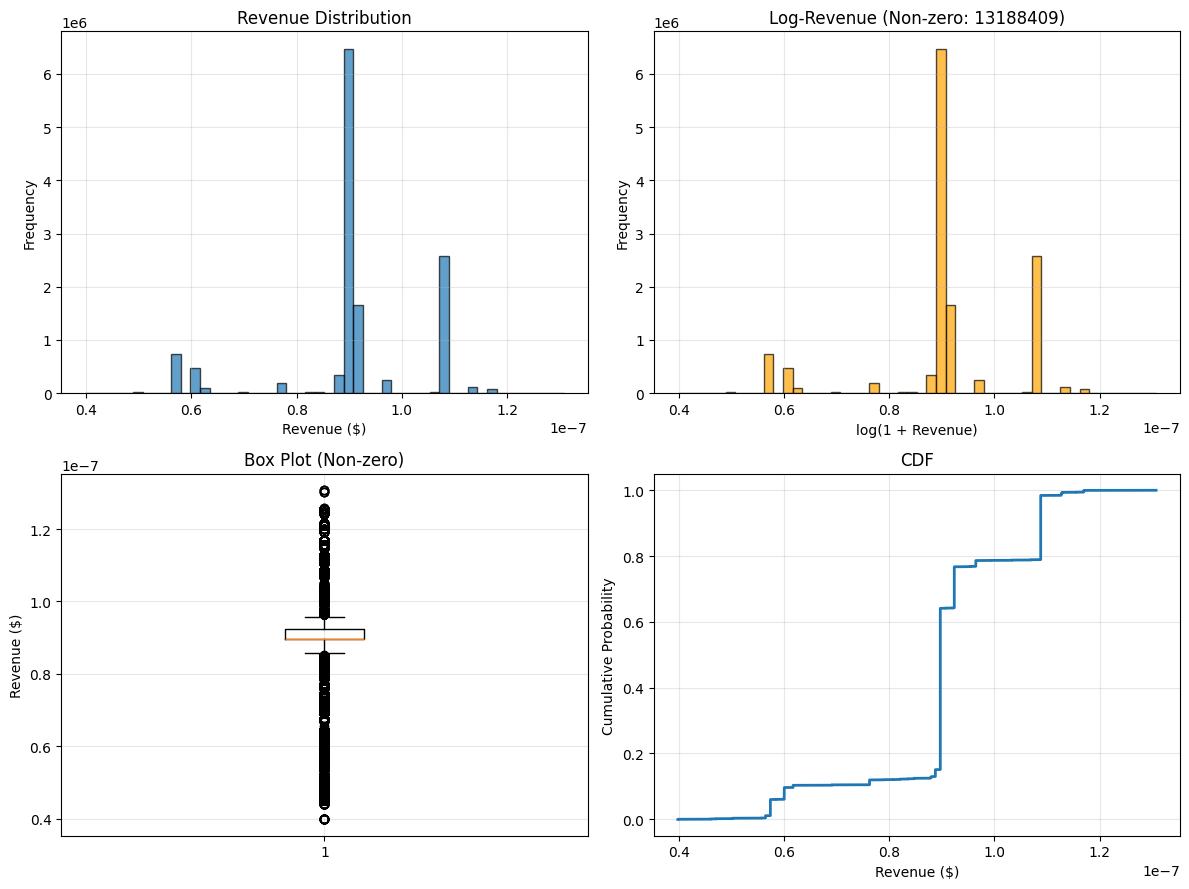

In [2]:
## 9. Explore Submission Results (Standalone)

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV
output_path = "outputs/submission_twostage.csv"
submission_df = pd.read_csv(output_path)
revenue = submission_df['iap_revenue_d7']

print("=" * 80)
print("SUBMISSION EXPLORATION")
print("=" * 80)

# Basic stats (with scientific notation for small values)
print(f"\nShape: {submission_df.shape}")
print(f"Min: {revenue.min():.8e}")
print(f"Max: {revenue.max():.8e}")
print(f"Mean: {revenue.mean():.8e}")
print(f"Median: {revenue.median():.8e}")
print(f"Std: {revenue.std():.8e}")

# Percentiles (scientific notation)
print(f"\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"  P{p:2d} = {revenue.quantile(p/100):.8e}")

# Class balance
zeros = (revenue == 0).sum()
non_zeros = (revenue > 0).sum()
print(f"\nZeros: {zeros} ({zeros/len(revenue)*100:.1f}%) | Non-zeros: {non_zeros} ({non_zeros/len(revenue)*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Histogram
axes[0, 0].hist(revenue, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Revenue Distribution')
axes[0, 0].grid(alpha=0.3)

# Log histogram (non-zero)
revenue_nz = revenue[revenue > 0]
axes[0, 1].hist(np.log1p(revenue_nz), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('log(1 + Revenue)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Log-Revenue (Non-zero: {len(revenue_nz)})')
axes[0, 1].grid(alpha=0.3)

# Box plot
axes[1, 0].boxplot(revenue_nz, vert=True)
axes[1, 0].set_ylabel('Revenue ($)')
axes[1, 0].set_title('Box Plot (Non-zero)')
axes[1, 0].grid(alpha=0.3)

# CDF
sorted_rev = np.sort(revenue)
cumulative = np.arange(1, len(sorted_rev) + 1) / len(sorted_rev)
axes[1, 1].plot(sorted_rev, cumulative, linewidth=2)
axes[1, 1].set_xlabel('Revenue ($)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('CDF')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/submission_analysis.png', dpi=100, bbox_inches='tight')
print(f"\n✓ Plot saved: outputs/submission_analysis.png")
plt.show()
print("\n" + "=" * 80)